## 1. Preparation

In [58]:
import os, sys
sys.path.append(os.path.abspath('../'))

### Import modules

In [59]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime


from storage import MongoDBStorageAdapter
from utils.tools import convert_to_str

## 2. Data fetching and preparation

In this section, our target is to get data and prepare them in the order to be visualized.

### 2.1. Fetch messages from MongoDB

Get raw messages

In [60]:
store = MongoDBStorageAdapter();

all_messages = store.get_all_msgs();

2019-11-16 15:25:29,353 - storage.models - INFO - Try to establish connection to MongoDB instance on mongodb:27017 as 'user' 


Flatten JSON into 2D table

In [61]:
from pandas.io.json import json_normalize

# Transform into flat JSON and make a DateFrame
df = json_normalize(all_messages)

# Make a reserve copy
res_df = df.copy()

Show columns

In [62]:
df.columns

Index(['_id', 'time', 'message_type', 'longitude', 'latitude', 'device.id',
       'device.device_type', 'payload.ssid', 'payload.bssid',
       'payload.signal.rssi'],
      dtype='object')

In [187]:
ap_names = df["payload.ssid"].unique()
metric_times = df['time'].unique()

### 2.2. Data Transforming

Transform data to required types

In [157]:
# using dictionary to convert specific columns 
convert_dict = {'longitude': float, 
                'latitude': float,
                'payload.signal.rssi': int,
               } 

df = df.astype(convert_dict) 

df["time"] = pd.to_datetime(df["time"])
df['time'] = df['time'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,dt.minute,))

### 2.3. Data Filtering

Prepare filter for out data

In [159]:
only_handies = df["device.device_type"] == "handy"
has_wifi = df["message_type"] == 'wifi'

Clear out our dataset

In [160]:
only_handies_with_wifi_df = df[only_handies][has_wifi]

Select only necessary columns

In [161]:
wifi_signal_quality_df = only_handies_with_wifi_df[["time","longitude","latitude","device.id",'payload.signal.rssi',"payload.ssid"]]

In [182]:
wifi_signal_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2839 entries, 0 to 2838
Data columns (total 6 columns):
time                   2839 non-null datetime64[ns]
longitude              2839 non-null float64
latitude               2839 non-null float64
device.id              2839 non-null object
payload.signal.rssi    2839 non-null int64
payload.ssid           2839 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 155.3+ KB


## 3. Visualization

In this section, we want to visualize our Wifi Quality Signal data with GPS location.

We target the following diagrams:

1. Mean signal quality estimation for AP  in Time.
2. Changes of GPS location for Client in Time.
3. Mean Estimated signal quality for AP per Location.

### 3.1. Mean signal quality estimation for AP  in Time.

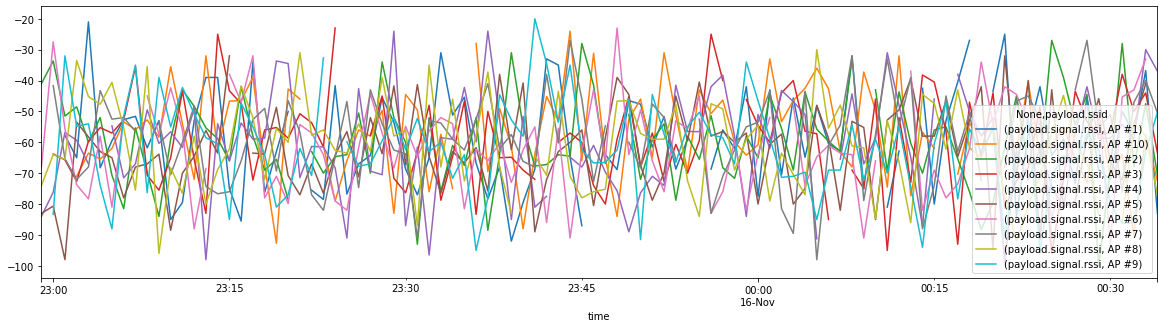

In [180]:
wifi_signal_quality_df[["payload.ssid","time","payload.signal.rssi"]].groupby(["time", "payload.ssid"]).mean().unstack().plot(figsize=(20,5))

In [144]:
grouped_ap_df = wifi_signal_quality_df.groupby(["payload.ssid",])

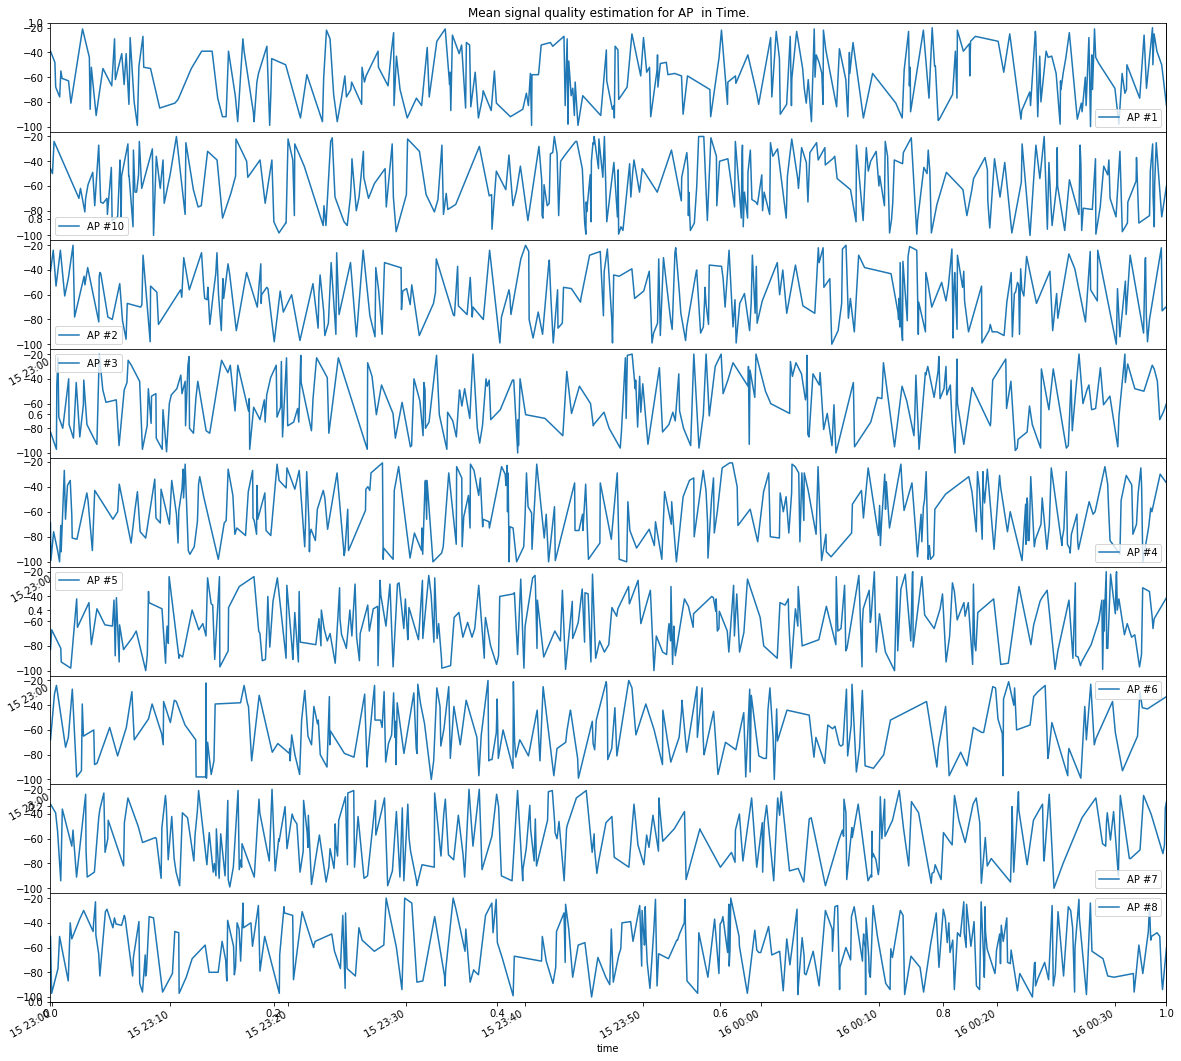

In [226]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0)
plt.title("Mean signal quality estimation for AP  in Time.")

for index,(name, group) in zip(range(1,len(ap_names)),grouped_ap_df):
    
    ax = fig.add_subplot(len(ap_names)-1,1,index)

    group.plot(x="time", y="payload.signal.rssi",ax=ax);
    plt.legend([name])

## GPS locations by hands

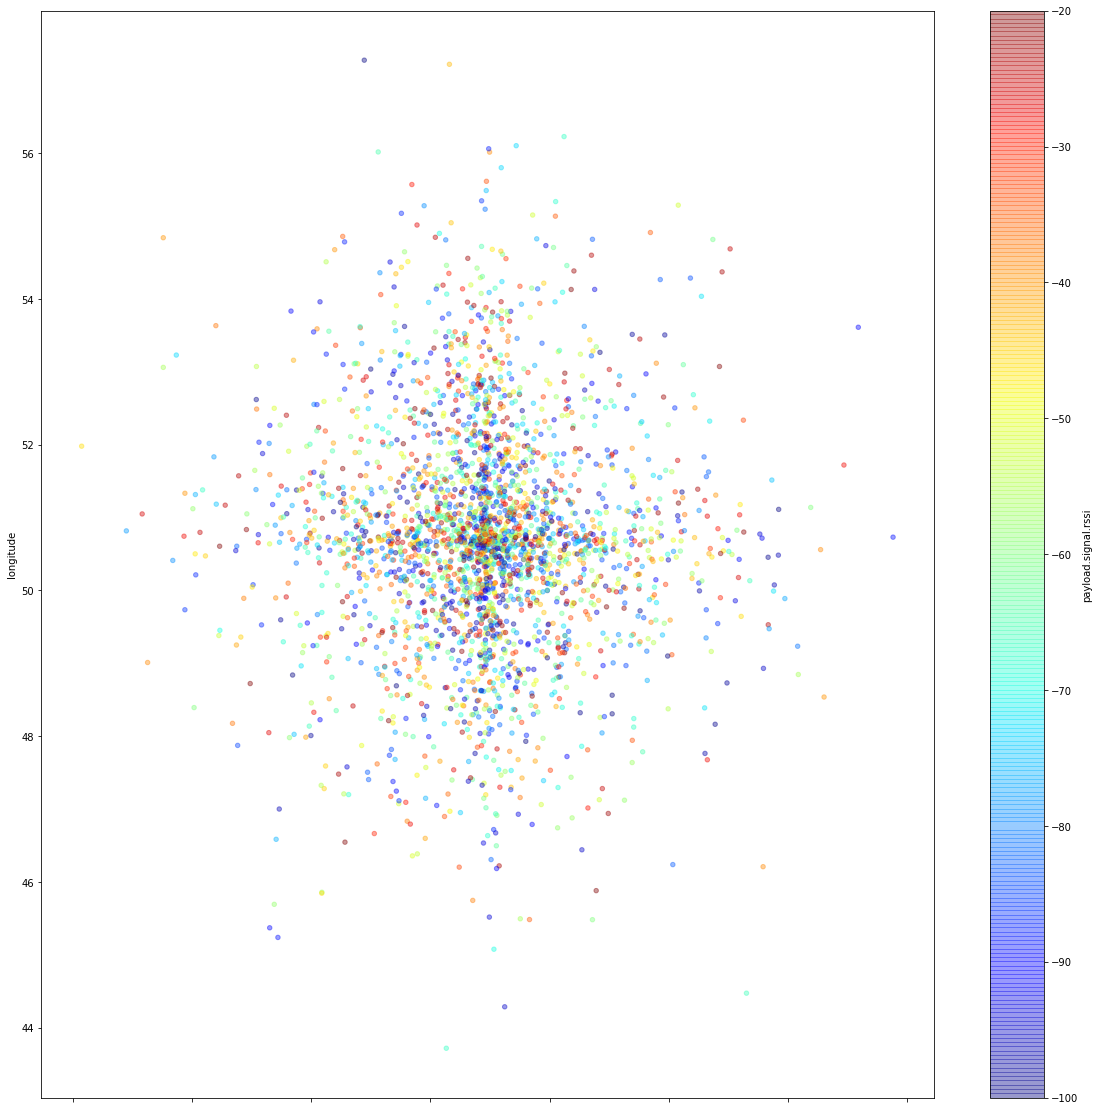

In [70]:
wifi_signal_quality_df.plot(kind="scatter", y="longitude", x="latitude", c="payload.signal.rssi", cmap=plt.get_cmap("jet"), alpha=0.4, figsize=(20,20))

## GPS Positions in the World

In [72]:
import descartes
import geopandas as gpd
from shapely.geometry import Point,Polygon

In [73]:
geometry = [Point(xy) for xy in zip(wifi_signal_quality_df["longitude"], wifi_signal_quality_df['latitude'])]

In [74]:
geo_df = gpd.GeoDataFrame(wifi_signal_quality_df,
      geometry = geometry)

geo_df.head()

,time,longitude,latitude,device.id,payload.signal.rssi,payload.ssid,geometry
0,2019-11-15 22:59:47.789534,49.265486,13.499028,68eaec53-9451-4e2d-8255-4928bb73d82f,-69,AP #4,POINT (49.26549 13.49903)
1,2019-11-15 22:59:49.793261,51.502581,11.992715,9e9f1f3d-6523-4492-b60f-ef09b8a5c6b0,-99,AP #4,POINT (51.50258 11.99272)
2,2019-11-15 22:59:51.796961,49.377491,8.248235,7f85b2bb-f93c-4e6e-9403-bcf86cf08d94,-51,AP #8,POINT (49.37749 8.24823)
3,2019-11-15 22:59:53.800831,53.230136,11.287466,c9dff19e-c344-4cb1-a33f-e21ce1b00a15,-41,AP #2,POINT (53.23014 11.28747)
4,2019-11-15 22:59:55.803512,48.242247,13.412806,68ffd193-ca72-4990-ad10-9ee0f4d2e0bf,-68,AP #6,POINT (48.24225 13.41281)


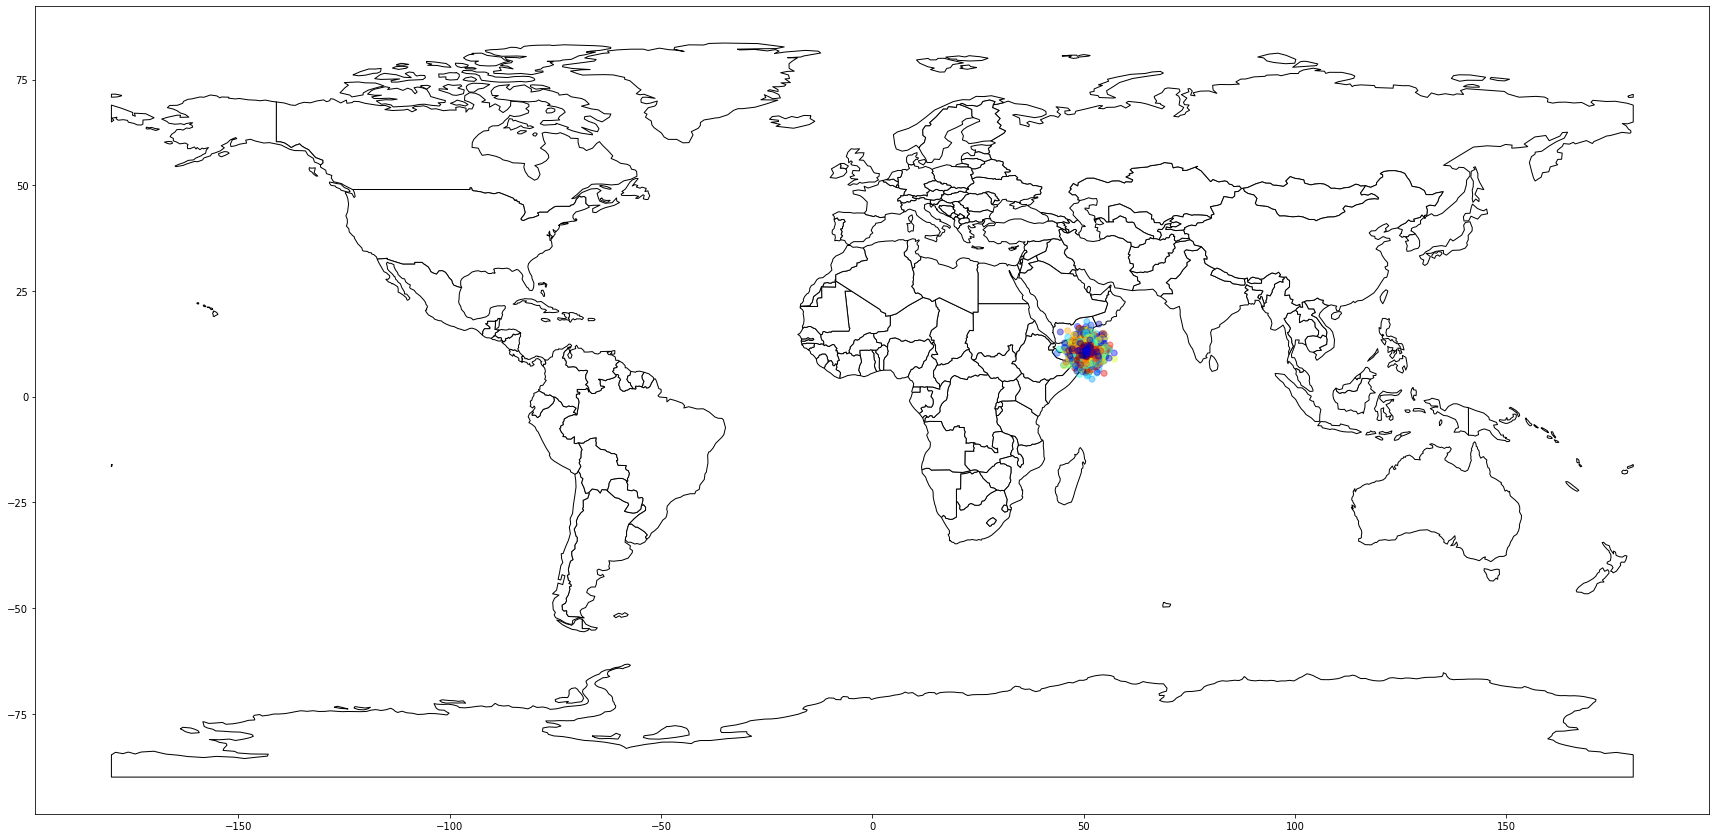

In [75]:
# https://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/
# https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


base = world.plot(color='white', edgecolor='black', figsize=(30,30),)


geo_df.plot(label="rssi",
    c="payload.signal.rssi", cmap=plt.get_cmap("jet"),
    alpha=0.4, figsize=(30,30), ax=base);